In [1]:
import variational_bayes as vb
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

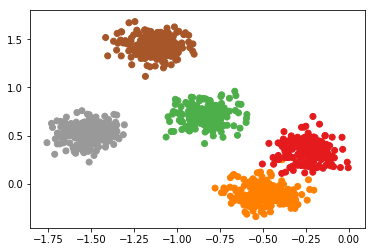

In [2]:
np.random.seed(9)
num_samples = 1000
num_groups = 5

z = np.random.choice(num_groups, num_samples)
group_mean = np.random.normal(0, 1, (num_groups, 2))
group_precision = np.random.gamma(100, 1, (num_groups, 2))

x = np.random.normal(0, 1, (num_samples, 2)) / np.sqrt(group_precision[z]) + group_mean[z]

plt.scatter(*x.T, c=z, cmap='Set1')

In [3]:
def mixture_model(num_groups):
    # Set up the factors
    q_mean = vb.MultiNormalDistribution(np.random.normal(0, 1e-3, (num_groups, 2)), 
                                        np.ones((num_groups, 1, 1)) * np.eye(2) * 1e-3)
    q_precision = vb.WishartDistribution(2 * np.ones(num_groups), np.ones((num_groups, 1, 1)) * np.eye(2) * 1e-3)
    q_z = vb.CategoricalDistribution(np.random.dirichlet(1000 * np.ones(num_groups), num_samples))
    
    # Evaluate the likelihood
    likelihood = vb.MultiNormalLikelihood(x[:, None], q_mean, q_precision)
    mixture_likelihood = vb.MixtureLikelihood(q_z, likelihood)
    
    mean_prior = vb.MultiNormalLikelihood(q_mean, np.ones(2), 1e-4 * np.eye(2))
    precision_prior = vb.WishartLikelihood(q_precision, 2, 0.2 * np.eye(2))
    z_prior = vb.CategoricalLikelihood(q_z, np.ones(num_groups) / num_groups)

    return vb.Model({'mean': q_mean, 'precision': q_precision, 'z': q_z}, 
                    [mixture_likelihood, z_prior, mean_prior, precision_prior])

Widget Javascript not detected.  It may not be installed or enabled properly.


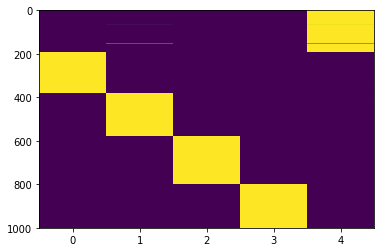

In [4]:
model = mixture_model(num_groups)
elbo = model.update(500, tqdm=tqdm_notebook)

plt.imshow(model['z'].mean[np.argsort(z)], aspect='auto')

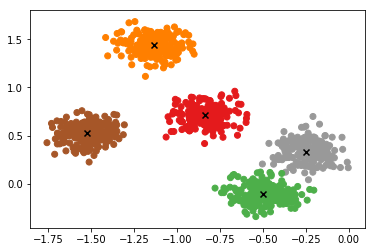

In [5]:
plt.scatter(*x.T, c=np.argmax(model['z'].mean, axis=1), cmap='Set1')
plt.scatter(*model['mean'].mean.T, marker='x', color='k')

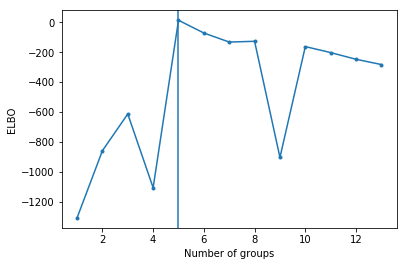

In [7]:
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
elbos = []

for n in tqdm_notebook(num):
    model = mixture_model(n)
    elbo = model.update(200)
    elbos.append(elbo[-1])
    
plt.plot(num, elbos, marker='.')
plt.axvline(num_groups)
plt.ylabel('ELBO')
plt.xlabel('Number of groups')